# Chapter 8: Time-Varying Volatility
&copy; 2019 Kenneth Winston

Benjamin Graham famously anthropomorphized the US stock market, attributing wild emotional swings to "Mr. Market[$^1$](#eight_footnotes)." Sometimes Mr. Market was fearful, usually after a sufficiently traumatic negative event. At those times Mr. Market would sell valuable assets cheaply. Other times Mr. Market was greedy, and was willing to pay unrealistically high prices. The essence of "value investing" espoused by Graham &mdash; and later by his most famous student, Warren Buffet &mdash; was to take advantage of Mr. Market's changing moods.

We noted when discussing mixtures of normals in Section 6.3 that authors such as [Ang & Timmerman 2008](https://dx.doi.org/10.2139/ssrn.1919497) found that markets
>often change their behavior abruptly
and... the new behavior of financial variables often persists for several periods after such a change.

In Section 6.3 we explored a model that does a good job of embodying the observation that markets "often change their behavior abruptly:" mixtures of normals. But mixtures of normals don't address the persistence that Ang & Timmerman and others have observed. In this chapter, we'll study models that are aimed at <u>both</u> realistic behavior change and realistic persistence.

## 8.1 Historical Volatility ##

We know that even draws taken from a well understood distribution will have considerable sampling variation. So is it possible that abrupt changes and regime persistence in volatility are just due to ordinary sampling variation?

Let's examine the volatility of the US stock market starting in 1927. To start, in the next cell we'll compute the annualized standard deviation of monthly log-returns from January 1927 to the end of last year. 

In [4]:
%matplotlib inline
import qrbook_funcs as qf
import numpy as np
#Find long-term standard deviation of US stock market
#Uses Ken French's website

#Cut off at last yearend
lastday=qf.LastYearEnd()
ld_yyyymm=int(lastday[:4]+lastday[5:7])
Date,market_minus_rf,SMB,HML,RF=qf.getFamaFrench3(enddate=ld_yyyymm)

ActualReality=qf.LogReturnConvert(market_minus_rf,RF)

#Compute overall monthly standard deviation
targetsd=np.std(ActualReality)

tstr='Annualized standard deviation of US stock market,\n'
tstr+=str(Date[0])[:6]+'-'+str(Date[len(Date)-1])[:6]
tstr+="(%.1f years)" % float(len(market_minus_rf)/12)
tstr+=': %.2f%%' % float(targetsd*np.sqrt(12))
print(tstr)

Annualized standard deviation of US stock market,
192607-201812(92.5 years): 18.42%


To see what sampling variation looks like, Figure 8.1 shows draws from a normal distribution with mean 0 and standard deviation equalling the historical standard deviation we just obtained.

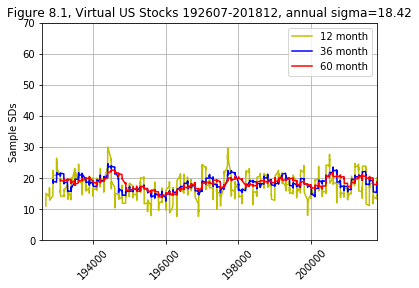

In [6]:
#Generate virtual reality with random normal draws with targetsd
import random

VirtualReality=[]
random.seed(3.14159265)
for x in range(len(ActualReality)):
    VirtualReality.append(random.gauss(0,targetsd))

#Generate sample standard deviations for 3 lookback periodicities
lookbacks=[12,36,60]
SampleSd=qf.GenSampleSd(VirtualReality,lookbacks)

#Draw the graph with 3 lines for the 3 periodicities
colors=['y-','b-','r-']
tstr='Figure 8.1, Virtual US Stocks '+str(Date[0])[:6]
tstr+='-'+str(Date[len(Date)-1])[:6]
tstr+=', annual sigma=%.2f' % float(targetsd*np.sqrt(12))
qf.PlotSampleSd(tstr,Date,SampleSd,lookbacks,colors)

We've labelled Figure 8.1 with dates. But these are not real dates &mdash; they are *merely corroborative detail intended to give artistic verisimlitude*[$^2$](#eight_footnotes) to the figure. Figure 8.1 is comprised of the same number of observations that we used above to find the long-term volatility of the US stock market, which is the target volatility in Figure 8.1. Otherwise, Figure 8.1 is virtual.

The yellow line shows sample standard deviations computed over rolling 12-month periods; blue shows annualized 36-month sample standard deviations; and red shows 60-month. The red line is the smoothest as it has the most opportunity to average out individual sampling quirks.

By comparison, Figure 8.2 shows reality: sample annualized standard deviations taken from real US stock market data over 12, 36, and 60-month trailing periods:

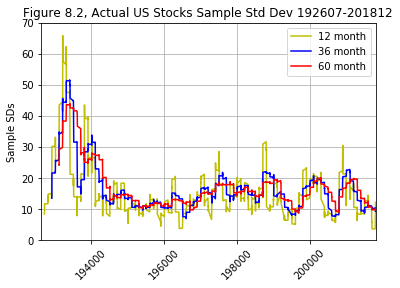

In [8]:
#Generate sample standard deviations
lookbacks=[12,36,60]
SampleSd=qf.GenSampleSd(ActualReality,lookbacks)

#Graph
colors=['y-','b-','r-']
tstr='Figure 8.2, Actual US Stocks Sample Std Dev '+str(Date[0])[:6]
tstr+='-'+str(Date[len(Date)-1])[:6]
qf.PlotSampleSd(tstr,Date,SampleSd,lookbacks,colors)

The differences between Figure 8.1 and Figure 8.2 are dramatic. The most obvious difference is the long high-volatility regime in Figure 8.2 consisting of the Great Depression of the 1920’s and 1930’s. This was far beyond the kind of sampling variation shown in Figure 8.1. Actual reality is more complicated than virtual reality. It would be nice to ignore that, but acting on the mistaken belief that we live in the world of Figure 8.1 will inevitably lead to a painful adjustment.

The standout features of Figure 8.2 are the spikes &mdash; especially evident in the yellow line &mdash; that occur because of large negative shocks: the Great Depression; the stock market crash of October, 1987; and in 2008-2009. None of these would have been observed if we had just sampled from a lognormal.

In addition to protuding periods of very high volatility in the real data, a close look reveals regimes of persistent low volatility. For example the two decades of the 1950's and the 1960's showed volatility mainly in the low teens, as did the period 2003-2006.

It certainly seems plausible that major economic events cause the financial markets to have volatility memory. In the Great Depression, it was not clear for quite a while whether or not the US would survive without major changes, if at all.

Fortunately there was not a complete break in the rule of law in the US. Complete breaks occur frequenty, almost inevitably, in history as we pointed out in Section 6.1.3 with examples in Russia, China and Cuba. On the other hand it could be argued that the New Deal legislation passed in the US in the wake of the Great Depression reshaped the social and economic contract, so there was a partial break.

The calm period of the 1950s and 1960s corresponded to a number of soothing factors &mdash; the end of a World War, stable demographics, household formation, etc.

The reasoning behind these large macroeconomic regimes can be extended to lesser events such as the [1986 Tax Reform Act](https://www.nber.org/papers/w2659.pdf) in the United States created. Anticipation and eventual passage of this law created short-term market volatility: the yellow line in Figure 8.2 spiked over 30% for three months at the end of 1986. But eventually markets adjusted to the new rules and volatility subsided.

## 8.2 Options and Volatility ##

We have noted that Harry Markowitz was apparently the first (in 1952) to suggest that volatility (standard deviation) was a good metric for how much information we lack about the future, i.e. Frank Knight's concept of risk.

We have also noted that we live in a world of Knightian Uncertainty, where we don’t know the probability distribution of outcomes. If we did, we would know future volatilities. But we don't even know how much we don't know about the future.

This lack of knowledge about our lack of knowledge is good news for market participants called **`volatility traders`**: they would not have jobs if everyone knew future volatility. But in fact there are lively markets where participants are able to express views about future volatility.

Many of the strategies to bet on future volatility involve options, so the next section briefly reviews options terminology.

### 8.2.1 Review of Options Terminology ###

The owner of a **`European call option`** has the right (but not the obligation) to purchase an underlying entity (such as a share of stock, or a unit of an index such as the Standard & Poors 500) at an agreed-on strike price on a certain date in the future. This date is called **`maturity`** or **`expiration`** of the option; after that date, the option no longer confers any power on its owner. If the call option owner chooses to use his or her right to purchase, s/he is said to have **`exercised`** the option. An **`American call option`** has the same properties, except it can be exercised on or before (not just on) a certain date in the future.

A **`call writer`** is one who agrees, at the call owner's discretion, to sell the underlying entity at the agreed-on price on (or before, if American) a certain date. The amount the call owner must pay to the call writer to gain the power to exercise is the **`call premium`**.

Many options are **`cash settled`**, meaning the purchase of the underlying does not actually occur. For example, if a call owner exercises the right to buy an underlying at a strike price of \\$100 at a time when its market price is \\$120, under cash settlement the call writer would simply pay \\$20 to the call owner. If the option is one with **`physical settlement`**, upon exercise the call owner pays the strike price to the call writer, who simultaneously delivers a unit of the underlying to the call owner.

In practice in many cases, calls are not bilateral contracts. Instead, an exchange (such as the [Chicago Board Options Exchange](www.cboe.com)) stands between all call owners and all call writers. Call owners pay the premium to the exchange and call writers receive the premium from the exchange, but the exchange collects collateral (called **`margin`**) from call writers to minimize the chance that they collectively fail to fulfill their obligations in the event of exercise. Upon exercise, physical or cash settlement also takes place through the exchange.

The owner of a **`put option`** has the right (but not the obligation) to sell an underlying entity to a **`put writer`** (or to an exchange standing between owners and writers) with conditions similar to a call option.

The **`put-call conversion`** equation expresses a key relationship between European options on the same non-dividend-paying underlying:
$$X+P-C=\$\label{eq:put_call_conversion}\tag{8.1}$$
Here $X$ is the price of the underlying and $P$ and $C$ are the prices of a put and a call, respectively, on the underlying. The put and the call have identical strike prices and maturities. \$ is the current price of a riskless zero-coupon bond that pays the common strike price at maturity.

Consider an investor who buys a unit of the underlying; buys a put on that underlying; and writes a call on that underlying. If, at maturity, the underlying is worth less than the strike price then the call will be worthless but the put will be worth the difference between the strike price and the underlying, so the three-position portfolio held by the investor will be worth the strike price. Similar logic shows that if the underlying is worth more than the strike price at maturity, the investor's three-position portfolio will also be worth the strike price. Thus by no-arbitrage, the conversion equation holds.

Options are a type of **`derivative security`**. Such securities derive their prices from other more fundamental observables, including stock prices, bond prices, commodity prices, and interest rates.

We noted at the beginning of Chapter 4 that the [Black-Scholes option formula](https://doi.org/10.1086%2F260062) is perhaps the most famous formula in mathematical finance. Under the assumption that underlying prices follow lognormal random walks as in \eqref{eq:sde_percentage_changes}, this formula expresses the price of a European call option as a function of five more basic variables:
- The current price of the underlying (such as the S&P 500);
- The strike price of the option;
- The time to maturity of the option;
- The risk-free rate of interest; and
- The volatility of the underlying’s log-returns.

### 8.2.2 Market Volatilities and Volatility Markets ###

Transcribing the list at the end of the previous section to functional form gives
$$Price(\text{option})=f(\text{underlying price}, \text{strike price}, \text{time},$$
$$\quad\quad\quad\text{rf rate}, \text{standard deviation})\label{eq:generic_option_pricing}\tag{8.2}$$

\eqref{eq:generic_option_pricing} is a plausible functional form for options prices, but unfortunately we already know from Chapter 6 that Black-Scholes's basic assumption of underlying lognormal random walks isn't true. We'll explore the implications of non-normality further below.

For now, note that the first four Black-Scholes inputs are easily observable. The fifth (volatility) can be observed in the past, but as we've pointed out above, volatility is not constant and we don't know what it will be over the future life of option.

While we can't observe future volatility, we might be able to observe current options prices. So when the options of interest are traded in a market like the [Chicago Board Options Exchange](www.cboe.com) or the [Eurex](https://www.eurexchange.com/exchange-en/products), we can rearrange \eqref{eq:generic_option_pricing} so that observables are on the right-hand-side:
$$ImpVol(\text{option})=g(\text{underlying price}, \text{strike price}, \text{time},$$
$$\quad\quad\quad\text{rf rate}, \text{option price})\label{eq:generic_implied_volatility}\tag{8.3}$$

The standard deviation that was on the RHS of \eqref{eq:generic_option_pricing} is rebranded as **`implied volatility`** in \eqref{eq:generic_implied_volatility}: its value is implied under the assumption that \eqref{eq:generic_option_pricing} holds. Often an iterative procedure rather than a closed-form formula is applied to \eqref{eq:generic_option_pricing} to determine the $g$ function in \eqref{eq:generic_implied_volatility}.

Higher underlying standard deviation means that more probability mass is pushed away from the center of the underlying's distribution, out to the tails. More probability in the tails means a higher probability of high values for an option. Thus, any sensible option pricing function $f$ in \eqref{eq:generic_option_pricing} will have a positive derivative with respect to its fifth argument, i.e.
$\frac{\partial f}{\partial \sigma}>0$ where $\sigma$ is the standard deviation argument on the RHS of \eqref{eq:generic_option_pricing}.

Thus the expectation of an underlying's volatility over the life of an option is closely linked to the price of that option. More expected volatility means a higher option price when all other arguments are held constant, and a higher option price reflects more expected volatility through \eqref{eq:generic_implied_volatility}. Because of this tight connection, sometimes options prices are quoted in volatility units rather than in monetary units.

So options markets can be seen as markets where underlying volatility is traded. A simple strategy that can express a view of future volatility is to buy  or write a **`straddle`**, which is a put option and a call option struck at the money and expiring at the same time in the future. (**`The money`** means the current price of the underlying.)

If we pay $p$ for the put and $c$ for the call, then if the underlying moves more than $p+c$ in either direction away from its current price, we will profit. If we knew future volatility, we would be able to tell if $p+c$ was too low (buy the straddle) or too high (write the straddle). Figure 8.3 shows the payoff patterns of the put, the call, and the straddle at time of maturity, where the strike is 100 and both the put and the call are assumed to cost 5.

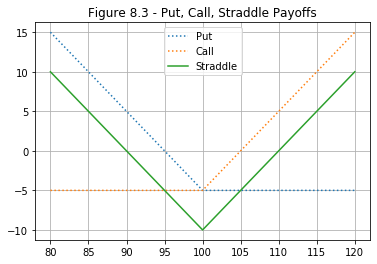

In [4]:
import matplotlib.pyplot as plt
#Draw graph showing payoff pattern of put,
#call and straddle

underprices=np.arange(80,121,1)

strike=100
cost=5
putprices=np.maximum(strike-underprices,0)-cost
callprices=np.maximum(underprices-strike,0)-cost
straddleprices=putprices+callprices
        
plt.plot(underprices,putprices,label='Put',linestyle=':')
plt.plot(underprices,callprices,label='Call',linestyle=':')
plt.plot(underprices,straddleprices,label='Straddle')
plt.title('Figure 8.3 - Put, Call, Straddle Payoffs') 
plt.legend()
plt.grid()
plt.show()

The most widely observed implied volatilities are those of the [Standard & Poors 500&reg;](https://www.spindices.com/indices/equity/sp-500), the US stock market index. The Chicago Board Options Exchange created the CBOE Volatility Index&reg;, more widely known as the [VIX&reg; Index](http://www.cboe.com/vix), to "measure the market's expectation of future volatility... based on options of the S&P 500&reg; Index."

The VIX&reg; has been [published daily by the CBOE](http://www.cboe.com/micro/vix/historical.aspx) since the early 1990s, and data has been backfilled to the beginning of 1986. An older series called VXO is based on a different methodology, but basically tells the same story as VIX. Figure 8.4 shows the historical values of VXO and VIX retrieved from the FRED database:

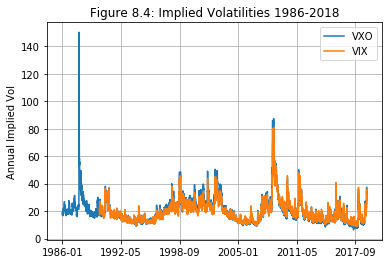

In [5]:
import pandas as pd
#Get VXO and  VIX from Fred and
#graph them.

lastday=qf.LastYearEnd()
seriesnames=['VXOCLS','VIXCLS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            enddate=lastday)

#Get rid of double nan's
vols=[]
vdates=[]
for i in range(len(ratematrix)):
    if pd.notna(ratematrix[i][0]) or pd.notna(ratematrix[i][1]):
        vols.append(ratematrix[i])
        vdates.append(cdates[i])

#vols now has VXO and VIX data where at least
#one of them is present.
x=range(len(vdates))
vxo=[row[0] for row in vols]
vix=[row[1] for row in vols]
plt.plot(x,vxo,label='VXO')
plt.plot(x,vix,label='VIX')
plt.title('Figure 8.4: Implied Volatilities '+vdates[0][:4]+'-'+vdates[len(vdates)-1][:4])

xskip=np.arange(0,len(vdates),1600)
tikskip=[vdates[x][:7] for x in xskip]
plt.xticks(xskip,tikskip)
plt.ylabel('Annual Implied Vol')
plt.legend()
plt.grid()
plt.show;

The very large spike on the left of Figure 8.4 is the all-time high annualized implied volatility of 150, observed as a result of the stock market crash of October 19, 1987. A spike of 80 was observed on October 27, 2008 as markets panicked over the possible breakdown of the global financial system. For context, we've seen above that the annualized volatility of the US stock market since 1927 is between 18 and 19 (percentage points).

Given the variation that is apparent in Figure 8.4, it is not surprising that markets for volatility are quite active. There are vehicles like [volatility and variance swaps](https://doi.org/10.3905/jod.1999.319129) and [VIX futures](http://cfe.cboe.com/cfe-products/vx-cboe-volatility-index-vix-futures) that allow positions to be taken on the future level of certain asset volatilities. This activity is called **`vega trading`** since "vega" is the term often used to denote an instrument's sensitivity to changes in underlying volatility.[$^3$](#eight_footnotes)

### 8.2.3 Volatility Skews ###

Figure 8.4 showed a single time-varying option-implied volatility for the Standard & Poors 500. But at any given time, for the same underlying there are many traded options with varying strike prices and varying maturities. Each of these options has an implied volatility obtained from \eqref{eq:generic_implied_volatility}. Since the underlying asset can have only one actual volatility, we might hope that all options on the same underlying have the same implied volatility.

They don't. Figure 8.5 shows implied volatilities for options on the same underlying (S&P 500) with the same maturity, but with moneyness varying along the X axis. (Moneyness is the ratio of the strike price of the option to the current price of the underlying.)

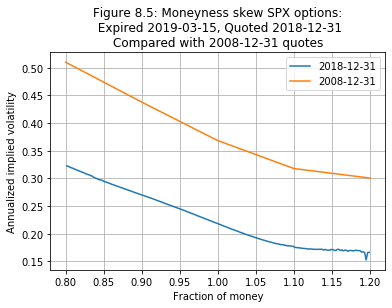

In [6]:
#Draw implied vols on two dates by moneyness
#Use downloaded file YYYY-12-31 from CBOE with all option prices on that day
#The full file takes a LONG time to read in, so code at the end of this
#chapter subsets it into more manageable pieces

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#Get all SPX options on CBOE as of December 31 of last year
yearend_string=str(datetime.datetime.now().year-1)+"-12-31"
df_opts=pd.read_excel(r"SPX_UnderlyingOptionsEODCalcs_"+yearend_string+".xlsx")

#Subset the S&P 500 options with underlying SPX (eliminate SPXW, weekly expirations)
df_spx = df_opts[(df_opts.underlying_symbol == "^SPX") & (df_opts.root == "SPX")]

#Get S&P 500 price and quote date
spx_price = df_spx.active_underlying_price_1545.unique()[0]
quote_date = df_spx.quote_date.unique()[0]
stqd = str(quote_date)[:10]    #Display version YYYY-MM-DD

#Look between 80% of the money and 120% of the money
df_spx=df_spx[(df_spx.strike > .8*spx_price) & (df_spx.strike < 1.2*spx_price)]

#Eliminate expirations less than a week
df_spx=df_spx[df_spx.expiration>quote_date+np.timedelta64(6,'D')]

#Show strike skew of March options
df_60to90=df_spx[(df_spx.expiration>quote_date+np.timedelta64(60,'D')) & \
                 (df_spx.expiration<quote_date+np.timedelta64(90,'D'))]

strikes=[]
implieds=[]
#Find closest to the money
min_to_money = min(abs(df_spx.strike.unique()-spx_price))
for strike in df_60to90.strike.unique():
    #Average the put and call implieds at this strike
    strikes.append(strike/spx_price)
    implieds.append(np.average(df_60to90[df_60to90.strike==strike].implied_volatility_1545))
    if abs(strike-spx_price)==min_to_money:   #record ATM 60-90 implied for later use
        spx_ATM_60to90_implied = implieds[-1]

str_exp=df_60to90.expiration.iloc[0].strftime('%Y-%m-%d')
plt.plot(strikes,implieds,label=stqd)

#Add December 2008 graph
moneyness=[.8,.9,1.,1.1,1.2] 
imp2008=[0.510000164, 0.437931821, \
         0.368329438,0.31789782,0.30067243]
plt.plot(moneyness,imp2008,label='2008-12-31')

plt.xlabel("Fraction of money")
plt.ylabel("Annualized implied volatility")
plt.legend()
plt.grid()
str_title="Figure 8.5: Moneyness skew SPX options:\n Expired "+str_exp+", Quoted "+stqd
str_title+="\nCompared with 2008-12-31 quotes"
plt.title(str_title)
plt.show()

The blue line in Figure 8.5 shows implied volatilities of S&P 500 options that matured on March 15, 2019, based on their December 31, 2018 market prices. From the rightmost part of Figure 8.4 we can see that volatility was a little elevated (around 25%) at the end of 2018. That's why much of the blue line is above .2 (20%). But we can further see that as moneyness varies, the blue line decreases monotonically except for slight pertubations at the high end where options are more thinly traded and the data are less reliable.

The red line in Figure 8.5 is the set of implieds on December 31, 2008, in the thick of the Global Financial Crisis. It's similar in shape to the blue line, but it's translated up (by about .15) on the Y axis.

This kind of monotone pattern, typical of equity options, is called a **`volatility skew`**. In some cases &mdash; currency options, often &mdash; the moneyness curve dips in the middle but comes up at both ends; this is called a **`volatility smile`**.

In Figure 8.5 maturity was held constant while moneyness varied. If we hold moneyness constant (at 100%) while maturity varies, we get the patterns shown in Figure 8.6.

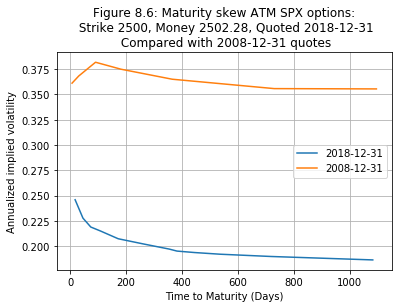

In [7]:
#Get time skew of ATM options
df_ATM=df_spx[abs(df_spx.strike-spx_price)==min_to_money]

times=[]
implieds=[]
for time in df_ATM.expiration.unique():
    #Average the put and call at this expiration date
    times.append(int((time-quote_date)/np.timedelta64(1,"D")))
    implieds.append(np.average(df_ATM[df_ATM.expiration==time].implied_volatility_1545))
    
#plt.plot(range(len(times)),implieds,label=stqd)
plt.plot(times,implieds,label=stqd)

#Add 2008-12-31 data
expiry=[7,31,91,182,365,730,1095] 
imp2008=[.3612,.3683,.3819,.3750, \
         .3651,.3558,.3555]
plt.plot(expiry,imp2008,label='2008-12-31')

plt.xlabel("Time to Maturity (Days)")
plt.ylabel("Annualized implied volatility")
plt.grid()
plt.legend()
str_strike=str(df_ATM.strike.iloc[0])
str_title="Figure 8.6: Maturity skew ATM SPX options:\n Strike "+str_strike
str_title+=", Money "+str(spx_price)+", Quoted "+stqd
str_title+="\n Compared with 2008-12-31 quotes"
plt.title(str_title)
plt.show();

The blue line in Figure 8.6 is a skew, although its range is not as wide as the moneyness skew in Figure 8.5. The maturity skew as of December 31, 2018 shows the option market's expectation that the then-current elevated level of volatility would subside.

The red line in Figure 8.6 is an upside-down smile, so of course it's called a **`volatility frown`**. In addition to the obvious highly elevated overall level, the red line shows the market's expectation that volatility would increase for about three months before subsiding slightly.

The downward slope &mdash; implied volatility decreases as moneyness increases &mdash; in Figure 8.5 is reliable, although the magnitude varies. The red line in Figure 8.7 is 120%-80% moneyness skew in one-month options; it's always 10% or more negative. That is, 120% moneyness annualized implied volatilities have always been at least 10% less than 80% moneyness implied volatilities of one-month options. There is some tendency for moneyness skew to increase during periods of market distress, like the terrorist attacks of September 11, 2001 or the Global Financial Crisis.

The blue line in figure 8.7 extends the anecdotal evidence of Figures 8.5 and 8.6: time skew is not as pronounced as moneyness skew. The blue line shows one year implied volatility minus one month implied volatility, both of at-the-money (100% moneyness) Standard & Poors 500 options. We used one year-one month because they are both heavily traded. This difference is usually (over 70% of the time) positive &mdash; during normal markets, investors tend to demand a volatility time premium, i.e. future implied volatility is higher than present implied volatility. But in market shocks, investors tend to buy short-term options rapidly and drive up near-term implied volatility. Thus time skew is a reliable market stress indicator.

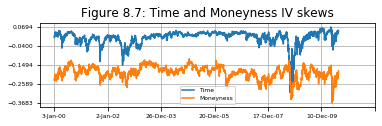

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
#Read time series of implied vol skews
#from csv file and graph them (time and
#moneyness skews)

file='IV skews.csv'
df=pd.read_csv(file)

#Change skew time series from strings to fractions
dates=df['Date']
timeskew=df['Time'].str.rstrip('%').astype('float')/100.0
moneyskew=df['Money'].str.rstrip('%').astype('float')/100.0

#Create a figure whose aspect ratio we can change
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(len(timeskew)),timeskew,label='Time')
ax.plot(range(len(moneyskew)),moneyskew,label='Moneyness')

ax.legend(loc='lower center',fontsize=6)
ax.grid()
plt.title('Figure 8.7: Time and Moneyness IV skews')
plt.xticks(range(0,len(timeskew)+500,500), \
          dates[dates.index % 500 == 0], \
          fontsize=6)
#Figure out size and spacing of y ticks
small=min(min(timeskew),min(moneyskew))
big=max(max(timeskew),max(moneyskew))
plt.yticks(np.arange(small,big+(big-small)/4,(big-small)/4), \
           fontsize=6)

ratio = 0.25   #x axis 4 times y axis
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
plt.show()

## 8.3 Volatility Models ##

The nonconstant implied volatilities in Figures 8.5 and 8.6 are further evidence &mdash; not that any was needed &mdash; that the simple lognormal random walk model of underlying prices \eqref{eq:sde_percentage_changes} is wrong. There is no way to reconcile the different implied volatilities with the idea of a lognormal underlying distribution with a single, time-invariant volatility parameter.

The Black-Scholes formula (and other option pricing formulas like [Cox-Ross-Rubenstein]()) are essentially theorems that follow from certain axioms. If a theorem doesn’t work empirically, then one of the axioms must be an incorrect description of reality. Mandlebrot used this line of reasoning as he examined the empirical failure of the Central Limit Theorem.

So we now turn our attention to what could be wrong with the assumptions behind the classical option pricing formulas, with the hope that we can get further insight, if not a perfect model. While the existence of active volatility markets mean that future volatility is unknown, that doesn't mean that we can't find patterns in volatility that can be used to generate descriptive models of the future.

These models are not prescriptive – they don’t predict volatility. But they do generate patterns of volatility that are very much like the patterns we see in the markets. Thus the versions of the future that they generate are more likely to encompass the possible outcomes and their associated probabilities than are constant volatility models.

### 8.3.1 Risk-Neutral Density Recovery ###

[Breeden and Litzenberger 1978](https://www.jstor.org/stable/2352653) decided to let the options market tell us what the underlying's distribution is, rather than try to tell the options market what it should be. Their approach is one of the ways to recover a risk-neutral cdf or pdf; from there we can apply the Ross Recovery Theorem as in Chapter 2.

A general way to write the price of a European call option is:
$$C(X,K,T,r)=exp(-rT)\int_{K}^{\infty}(y-K)f_{X,T}(y)dy
\label{eq:generic_option_integral}\tag{8.4}$$
This is a more explicit version of \eqref{eq:generic_option_pricing}: $X$ is the current price of the underlying; $K$ is the strike price; $T$ is the time to expiration; and $r$ is the risk-free rate over the life of the option. $f_{X,T}$ is the pdf of the underlying at time $T$ from now given that its current price is $X$.

Following Breeden & Litzenberger, we want to use observable options prices to recover the pdf $f_{X,T}$. Their technique does not disentangle risk preferences from probabilities, so the density function we recover will be risk-neutral like $q(x)$ in Chapter 2, not $p(x)$.

Manipulating \eqref{eq:generic_option_integral}, we can write
$$exp(rT)C(X,K,T,r)=\bigl(\mu-\int_{-\infty}^K{}yf_{X,T}(y)dy\bigr)-K(1-F_{X,T}(K))\label{eq:breeden_litz_1}\tag{8.5}$$
Here $\mu$ is the average value of the underlying over the pdf $f_{X,T}$, and $F_{X,T}(x)$ is the cumulative distribution function arising from the density function $f_{X,T}$.

Taking the derivative of both sides of \eqref{eq:breeden_litz_1}with respect to the exercise price $K$ gives
$$exp(rT)\frac{\partial C(X,K,T,r)}{\partial K}=-Kf_{X,T}(K)-1+F_{X,T}(K)+Kf_{X,T}(K)$$
The $Kf_{X,T}(K)$ terms cancel and we can write
$$F_{X,T}(K)=exp(rT)\frac{\partial C(X,K,T,r)}{\partial K}+1\label{eq:breeden_litz_2}\tag{8.6}$$
This gives an expression for the previously unknown cumulative density function in terms of the rate of change in the prices of options as strike prices change. We can approximate the derivative on the RHS of \eqref{eq:breeden_litz_2} by taking successive differences of observable options prices with incrementally higher strike prices, i.e. using finite differences $\Delta C/\Delta K$ to approximate the derivative. For example if we have a 3-month option struck at 90 and another 3-month option struck at 90.5, then two times the difference between their market prices will approximate the three-month forward cdf around 90.5.

Taking the derivative of \eqref{eq:breeden_litz_2} produces the pdf:
$$f_{X,T}(K)=exp(rT)\frac{\partial^2 C(X,K,T,r)}{\partial K^2}\label{eq:breeden_litz_3}\tag{8.7}$$
So if $C_1, C_2, and C_3$ are the market prices of options struck at 90, 90.5, and 91, respectively, then
$$exp(rT)\frac{C_3-2C_2+C_1}{.5^2}$$
is an approximation to the risk-neutral pdf of the underlying around 90.5.

In practice, applying \eqref{eq:breeden_litz_3} (or its finite difference approximation) produces bumpy distributions. Some options may be thinly traded, producing asynchronous quotes that lead to noisy pdfs. Often some kind of smoothing method, like a cubic spline, is applied to fill and smooth the recovered pdf. Another approach is to fit a smooth function to the observed moneyness volatility curve like those in Figure 8.5. Then the smoothed volatilities can be used as inputs to \eqref{eq:generic_option_pricing} to get prices that are input to \eqref{eq:breeden_litz_3}.

The risk-neutral distribution that results from this recovery and smoothing process can be used by traders to suggest arbitrage ideas in places where the trader feels the options market is being particularly unreasonable; too risk-averse; or not risk-averse enough.

### 8.3.2 Real-World Density Recovery ###

The recovered risk-neutral density function can be used together with the Ross Recovery Theorem (Section 2.9 above) to find real-world densities implied by observable options prices under Ross's assumptions.

We noted in Section 2.9 that observable options prices could be used to produce a square $n\times n$ matrix $Q$ whose $(i,j)$ entry is the probability of transitioning from state $i$ to state $j$ over a given time period. To form $Q$ we need to observe options prices at many different strikes and maturities.

For example, suppose we can observe prices of options expiring in one month with strikes of $90, 90.5, \dots, 110$. That would allow us to form $n=39$ second differences, corresponding to 39 states to which the Ross Recovery Theorem can be applied. State 1 is a price of $90.5$; state 2 is a price of $91$, $\dots$, state 39 is a price of $109.5$. 

Let’s say the current state's index is $c=20$, i.e. a price of \\$100. Then the prices of one-month options that are currently trading will let us fill in the $c^{th}$ row of the desired $Q$ matrix, where $Q$'s given time period is one month. But what do we do to fill in other rows of $Q$? For example suppose $i$ indexes the state where the underlying's price is $105$ and $j$ indexes the state where the underlying's price is $98.5$. How do we find $q(i,j)$, the probability of transitioning from \\$105 to \\$98.5 over one month?

To fill in the rest of $Q$, we'd need to look at prices of options that expire in two months; in three months; $\dots$; in 39 months. In practice it would be unlikely that we'd have all the necessary observations, but we might be able to fill in all the requisite data by interpolating between observed prices.

Once we have all $n$ second differences of prices (39 in our example, derived from 41 strike prices) over all the maturities (each of the next 39 months in our example), we can form a $n\times n$ matrix $Q_c$ whose $(i,t)$ entry is $q(c,i,t)$: the probability of transitioning from the current state $c$ to state $i$ between now and time $t$, $t=1,\dots,39$.

The $c$ row of the desired matrix $Q$ is the first column of the matrix $Q_c$, i.e. the vectors marked in red below are the same:

$$
 Q=
  \left[ {\begin{array}{ccc}
   \vdots & \ddots & \vdots\\
   \color{red}{q(c,1)} & \color{red}{\cdots} & \color{red}{q(c,m)} \\
   \vdots & \ddots & \vdots\\
  \end{array} } \right]
$$

$$
 Q_c=
  \left[ {\begin{array}{ccc}
   \color{red}{q(c,1,\Delta t=1)} & \ddots & q(c,1,\Delta t=m)\\
   \color{red}{\vdots} & \cdots & \vdots \\
   \color{red}{q(c,m,\Delta t=1)} & \ddots & q(c,m,\Delta t=m)\\
  \end{array} } \right]
$$

From this observation we can bootstrap the rest of $Q$ by noting that going from now (time 0) to state $i$ at time $t$ means we went from now to state $j$ at time $t-1$, and then did a one-month transition from state $j$ to state $i$. Summing, we get
$$q(c,i,\Delta t=t)=\sum_{j=1}^n q(c,j,\Delta t=t-1)q(j,i)$$

In other words, the $(i,t)$ entry of the known matrix $Q_c$ is the dot product of:
- column $i$ of the as-yet-unknown $n\times n$ matrix $Q$; and
- column $t-1$ of $Q_c$.

We also know &mdash; since things have to transition from somewhere or to somewhere &mdash; that $Qu=Q^{\prime}u=u$ where $u$ is the vector of all ones.

Putting the observations of the previous two paragraphs together in a matrix equation gives
$$\bigl(Q_c(2,n) | u\bigr)=Q^{\prime}\times\bigl(Q_c(1,n-1) | u\bigr)$$
where $Q_c(a,b)$ consists of columns $a$ through $b$ of $Q_c$ and "$|u$" means we append a column of all ones after the last column of the matrix.

Solving for $Q^{\prime}$ gives
$$Q^{\prime}=\bigl(Q_c(2,n) | u\bigr)\bigl(Q_c(1,n-1) | u\bigr)^{-1}\tag{8.12}$$
This retrieves the entire risk-neutral one-period state transition matrix from the Breeden-Liztenberger risk-neutral probabilities extracted from multiple time periods.

Getting this process to work in practice requires a lot of assumptions and a lot of data. We won't really have the $n(n+2)$ independent observations needed, and the way we fill in missing observations can affect the spectral analysis described in Section 2.9. But when used with caution, this process can deliver a partial description of a possible real-world density function of an underlying implied by market prices of its options.

### 8.3.3 Stochastic Volatility Modeling ###

The Black-Scholes model for option pricing started with the assumption that the underlying variable $x_t$ &mdash; for example the price of a stock at time $t$ &mdash; followed a lognormal stochastic process like the ones we introduced in Chapter 3:
$$\frac{dx}{x}=\alpha dt + \sigma d\beta\label{eq:repeat_sde}\tag{3.22}$$

Of course our point in this chapter is that it's unrealistic to assume that $\sigma$ is a constant. $\sigma$ varies in every way possible &mdash; over time; as $x_t$ varies; even when none of the variables in \eqref{eq:repeat_sde} vary, i.e. across option strike prices or expiration times.

So starting in the 1980's, a number of models were created that attempted to improve \eqref{eq:repeat_sde} by removing the requirement that volatility is constant:
$$\frac{dx_t}{x_t}=\alpha dt + \sigma(t,x_t) d\beta\label{eq:svm_sde}\tag{8.15}$$

But \eqref{eq:svm_sde} is just notation. The difficulty is in finding a realistic model for $\sigma(t,x_t)$. For one thing, realistic models will need to reflect the fact that volatilities are range-bound: they can't be negative and they can't increase forever. In fact volatilities of risky assets can't even stay near zero for very long periods because then the asset would be risk-free.

If volatilities could increase forever then swings would get more and more violent, and the stability necessary for market participants to have enough confidence to trade would be lost. [William Butler Yeats](https://www.poetryfoundation.org/poems/43290/the-second-coming) poetically expressed conditions of unbounded volatility:
>*Turning and turning in the widening gyre;<br>
The falcon cannot hear the falconer;<br>
Things fall apart; the centre cannot hold<br>
Mere anarchy is loosed upon the world*

Yeats was commenting on the chaos leading to World War I. As we've previously seen, the complete demises of markets in Russia, China, and Cuba were consequences of wider societal restructurings where "things fell apart." Wild market swings accompany wars and revolutions; they both reflect the widening gyre, and add to it. Anecdotally it appears that the centre cannot hold above a sustained $50\%$ annualized standard deviation of log-returns, although short-lived spikes above this level are often seen.

So modelers used <a href="#ornstein_uhlenbeck">Ornstein-Uhlenbeck</a> processes to capture the range-bound nature of variance (and volatility, its square root). The [Heston 1993 model](https://doi.org/10.1093%2Frfs%2F6.2.327), for example, is
$$dv(t)=\kappa[\theta-v(t)]dt+\varphi\sqrt{v(t)}dz(t)\label{eq:heston_model}\tag{8.16}$$
Here $v(t)=\sigma^2(t,x)$ is variance, but Heston's model does not make use of the $x$ argument. $dz$ is a Wiener process with correlation $\rho$ with the underlying's process $d\beta$. $\kappa$, $\theta$, and $\varphi$ ("volvol," the volatility of volatility) are constant parameters. Heston notes that \eqref{eq:heston_model} is the same equation as Cox, Ingersoll, and Ross's short rate model (3.61).

Models like \eqref{eq:heston_model} are called **`Stochastic Volatility Models`**. If $2\kappa\theta>\varphi^2$ (the "Feller Condition"), then the variance will almost surely stay above zero[$^4$](#eight_footnotes).

[Heston 1993](https://doi.org/10.1093%2Frfs%2F6.2.327) derives a closed-form formula for stock, bond, and currency options based on \eqref{eq:svm_sde} and \eqref{eq:heston_model}. The formulas are messy and involve some numerical integration. A large literature accompanied and followed Heston's results with variants and generalizations.

We noted in Chapter 3 that the original Vasicek model for short interest rates contemplated constant parameters. This was later generalized by Hull and White (and others) to allow nonstochastic but time-varying parameters to better capture interest rate curves. Similarly, parameters in \eqref{eq:heston_model} can be made to vary in a way that models the various types of skew that we saw in Section 8.2 above.

### 8.3.4 Local Volatility Modeling ###

[Bruno Dupire](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.320.5063&rep=rep1&type=pdf) and others took a different approach to the varying nature of $\sigma(t,x_t)$. Dupire’s approach relied on the Breeden-Litzenberger process to extract from options price an implied time-varying probability density function $f(t,x)$ for the underlying asset $x$.

The **`local volatility model`** (“LVM”) starts with a particular expiration series of options, say those expiring one month from now. It computes the density function $f(1/12,x)$ using \eqref{eq:breeden_litz_e} and some kind of interpolation/smoothing algorithm to treat the market’s inconsistency.

In fact for every time at which options expire $tex_1, tex_2,\dots, tex_n$ (and for which there is a robust set of traded options prices), the LVM computes the density function $f(tex_i,x)$ for that time. Another interpolation/smoothing algorithm is applied between expiration times to produce a single smooth density function $f(t,x)$.

Dupire’s insight was that the density function could be mapped into a volatility surface $\sigma(t,x)$. That is, it is possible to find a volatility function $\sigma(t,x)$ that:
- when used with \eqref{eq:svm_sde} and an option pricing method like Black-Scholes, produces the observed option prices in the market; and
- is consistent with the market-derived density function $f(t,x)$.

Dupire used the Fokker-Planck equation that ties together volatilities and density functions. Dupire shows that when applied to \eqref{eq:svm_sde}, it says
$$\frac{\partial f(t,x)}{\partial t}=\frac{\partial}{\partial x}\bigl(\alpha xf(t,x)\bigr)+\frac{\partial^2}{\partial x^2}\bigl(\frac{\sigma^2(t,x)}{2}f(t,x)\bigr)\label{eq:dupire_fokker}\tag{8.17}$$

We've dropped the subscript “t” on $x$ here, but it’s the same $x$ as in \eqref{eq:svm_sde}. \eqref{eq:dupire_fokker} can be solved for $\sigma(t,x)$ so that the two conditions above are satisfied. 

Black-Scholes and the related Black model for forward contracts have become familiar quoting conventions. Market participants essentially pretend that the innovations in \eqref{eq:svm_sde} are normal and put the non-normality in the variable $\sigma(t,x)$. The Local Volatility Model ties together time-varying volatility and the underlying distribution, so that the shapes (skews, smiles, smirks, frowns...) that are empirically evident can be mapped into a distribution. This allows options traders to think in terms of volatility surfaces (graphical representations of $\sigma(t,x)$) rather than in terms of pdf's.

### 8.3.5 SABR Modeling ###

Unfortunately there is a flaw in the LVM. It does not actually reflect reality as current prices change. We'll show how the problem and give a brief description of the widely used SABR model that solves the problem. A full investigation of SABR is beyond our scope.

Massimo Morini[$^5$](#eight_footnotes) notes the following. Let the current price (the "money") of the underlying be $x_0$. Extend our notation so that $\sigma(x_0;t,x)$ means the volatility surface estimated through the LVM process when the current ($t=0$) price is $x_0$, the time to expiration is $t$, and the strike price is $x$.

Then instantaneously shock the current price up a little bit, $x_0\to x_0+epsilon$. The volatility surface will change. It's reliably observed in practice that the surface shifts up, $\sigma(x_0+\epsilon,t,x)\approx\sigma(x_0;t,x-\epsilon)$. This is shown in Figure 8.8, where the red curve is the original blue curve shifted right by 5.

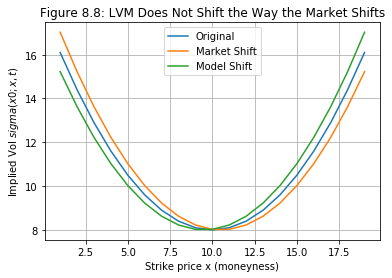

In [9]:
#Draw two smiles illustrating problem
#with LVM vs Market

strikes=np.arange(1,20)
original=[(s-10)**2/10+8 for s in strikes]
mktshift=[(s-.5-10)**2/10+8 for s in strikes]
modelshift=[(s+.5-10)**2/10+8 for s in strikes]

plt.plot(strikes,original,label='Original')
plt.plot(strikes,mktshift,label='Market Shift')
plt.plot(strikes,modelshift,label='Model Shift')

plt.ylabel('Implied Vol '+r'$sigma(x0;x,t)$')
plt.xlabel('Strike price x (moneyness)')
plt.grid()
plt.legend()
plt.title('Figure 8.8: LVM Does Not Shift the Way the Market Shifts')
plt.show()

Unfortunately it can be shown that the LVM does the exact opposite – it shifts the perturbed curve to the left (green curve). I have shown a perfect smile in the graph, but the right-shift seems to occur with imperfect smiles and with skews. I don't have a lot of intuition about why this occurs, but when a model contradicts a reliable market phenomenon, the model is wrong.

[Hagan et. al. 2002](https://web.archive.org/web/20150329204211/http://www.wilmott.com/pdfs/021118_smile.pdf) helpfully pointed out the shortcomings of the LVM model and put forward a new model that is still widely used. We'll just state the basic components of the **`SABR (Stochastic Alpha, Beta, Rho)`**, but won't pursue it further:

$$dx(t)=\sigma(t)x(t)^{\beta}dZ_x(t)$$
$$d\sigma(t)=\varphi\sigma(t)dZ_{\sigma}(t);\enspace\sigma(0)=\alpha\label{eq:sabr_model}\tag{8.19}$$
$$\mathbb{E}[dZ_xdZ_{\sigma}]=\rho dt$$
Like the Heston model \eqref{eq:heston_model}, SABR has a volvol φ and a correlation ρ between volatility and the underlying. However the dynamics are different and seem to fit market behaviors better.

## 8.4 Time Series Terminology ##

We will finish our study of time-varying volatility with the work of Robert Engle, Tim Bollerslev, and others who used time series techniques. For that, we'll need the terminology that we'll use for basic time series analysis. This section sets out our terminology and is not intended as course in time series, but rather as a reference for readers with knowledge of time series.

A **'time series'** is a set of data $X_t$ indexed by time. Typically values of $X_t$ where $t$ is in the past are simply data, while future values of $X_t$ are assumed to follow a stochastic process. For our purposes the stochastic process will be discrete and will contain data at a certain **`periodicity`**. The period can be a microsecond, a minute, a decade, or any other fixed amount of time.

We can define conditional distributions based on previous observations of the time series. When $t_1>t_2$, the notation $F[X_{t_1} | \{X_s, s\leq t_2\}]$ indicates the cdf for a future value $X_{t_1}$ of the time series given the information in previous values $\{X_s, s\leq t_2\}$. If we have a closed form for the conditional distribution $F[X_{t_1} | \{X_s, s\leq t_2\}]$, then the time series is **`autopredictive`**.

The conditional distribution framework reasonably contemplates us updating our beliefs. As the clock ticks (as $t$ increases), we build up more and more history. We get closer to the present, and eventually as the future becomes the present, variables become fixed and not stochastic. Suppose for example that $t_1=$the year 2050 and we form our belief as to the distribution of stock prices in 2050 based only on information about the stock market up to the year $t_2=2010$. That distribution will be different than the one we form if we have information about the stock market up to $t_2=2049$.

A time series is **`strongly stationary`** if $F(X_i,\dots,X_m)=F(X_{i+j},\dots,X{m+j})$ for all $i\leq n$ and $j\geq 0$. It is **`nonstationary`** if not. A weaker form of stationarity is **`covariance stationarity`**, meaning $\mathbb{E}[X_t]$ is a constant independent of $t$, and $Cov(X_t,X_s)$ is only a function of $t-s$. Thus Variance$(X_t)$ is only a function of $t-t=0$, i.e. like the mean, variance is a constant independent of $t$ for a covariance stationary time series. A strongly stationary time series is covariance stationary if it has finite variance; it is however possible to find infinite variance strongly stationary time series that are not covariance stationary.

Many time series are not stationary, but often techniques are used to transform them into stationary series, which are easier to deal with.

The (possibly time-varying) mean $\mu(t)$ of a time series is straightforward: $\mu(t)=\mathbb{E}[X_t]$. The **`autocovariance function`** of a time series is $\sigma(s,t)=\mathbb{E}[(X_s-\mu(s))(X_t-\mu(t))]$. The **`autocorrelation function`** is $\rho(s,t)=\frac{\sigma(s,t)}{\sqrt{\sigma(s,s)\sigma(t,t)}}$.

If the time series is covariance stationary, then we can define the autocovaraiance function as $v(s-t)\equiv \sigma(s,t)$, i.e. all that matters is the difference in times. Similarly the autocorrelation function can be written $r(s-t)\equiv \rho(s,t)=v(s-t)/v(0)$ for a covariance stationary time series.

A time series is **`autoregressive of order p`** (written $AR(p)$) if the following holds for all $t$:
$$X_t=c+\sum_{i=1}^p{a_i X_{t-i}}+\epsilon_t\label{eq:arp_definition}\tag{8.20}$$
Here $c,a_1,\dots,a_p$ are constants and the $\epsilon_t$ are iid with mean $0$ and variance $\sigma^2$. Often we start with initial conditions, where $X_0,\dots,X_{p-1}$ are known with certainty. We then begin introducing randomness through **`shocks`** (or **`innovations`**) embodied in the $\epsilon_t$.

Consider for simplicity an AR(1) process:
$$X_t=c+aX_{t-1}+\epsilon_t\label{eq:ar1_process}\tag{8.21}$$
The first step from the initial condition brings us to
$$X_1=c+aX_0+\epsilon_1$$
Iterating the AR(1) relationship up to time $t$, we obtain
$$X_t=\bigl(c\sum_{i=0}^{t-1}{a^i}+a^tX_0\bigr)+\sum_{i=1}^t{a^{t-i}\epsilon_i}=\bigl(c\frac{1-a^t}{1-a}+a^tX_0\bigr)+\sum_{i=1}^t{a^{t-i}\epsilon_i}\label{eq:ar1_iterated}\tag{8.23}$$

Note that if $|a|<1$, the term in large parentheses in \eqref{eq:ar1_iterated} converges to $c/(1-a)$ as $t\to\infty$, and if $|a|\geq 1$ the term is either unbounded or does not converge. For the AR(1) process to be stationary we must have $|a|<1$.

More generally for an AR(p) process, we can define the **`characteristic equation`**
$$z^p-a_1 z^{p-1}-\dots-a_p=0\label{eq:arp_characteristic}\tag{8.24}$$
The AR(p) process will be stationary iff the roots of this characteristic equation are all less than one in absolute value; i.e. they lie inside the unit circle on the complex plane. If any roots are outside the unit circle the process is ill-behaved: it rapidly heads off to infinite values. If there are roots on the unit circle and none outside the unit circle, then the process is a nonstationary “unit root” process that meanders.

Recall from Chapter 3 that a Markov Process is one where the current distribution’s dependence on the past is limited to its dependence on the immediate previous distribution, not the entire history of how we got there.
$$Pr[X_n=v_n | X_{n-1}=v_{n-1},\dots,X_{0}=v_{0}]=Pr[X_n=v_n | X_{n-1}=v_{n-1}]\tag{3.26}$$
Thus an AR(1) process is essentially a Markov process, since (using \eqref{eq:ar1_process}):
$$Pr[X_n=v_n | X_{n-1}=v_{n-1},\dots,X_{0}=v_{0}]=Pr[\epsilon_n=v_n-c-av_{n-1}]=Pr[X_n=v_n | X_{n-1}=v_{n-1}]$$

A generalized definition of a Markov process is one where the current distribution depends only on a fixed finite number $p$ of previous observations, not the entire history. Thus an AR(p) process fits this more general definition of a Markov process.

Assume for simplicity that the parameter $c$ in an AR(p) process \eqref{eq:arp_process} is zero and therefore all means are zero. Multiply the defining equation by $X_{t-k} (k>0)$ and take expectations to get:
$$\mathbb{E}[X_t X_{t-k}]=\sum_{i=1}^p{a_i\mathbb{E}[x_{t-i}X_{t-k}]}\tag{8.25}$$
If the process is stationary, only the difference in times matters in defining autocovariances, so we have
$$v(k)=\sum_{i=1}^p{a_i v(k-i)}\quad and \quad v(0)=\sum_{i=1}^p{a_iv(-i)}+\sigma^2=\sum_{i=1}^p{a_iv(i)}+\sigma^2\tag{8.26}$$

Dividing both sides of the left-hand equation by $v(0)$ converts the v’s (autocovariances) to r’s (autocorrelations) and gives rise to a series of linear equations called the **`Yule-Walker equations`** (noting r(-i)=r(i)):

$$
  \left[ {\begin{array}{c}
   r(1)\\
   r(2) \\
   \vdots \\
   r(p) \\
  \end{array} } \right]
=
  \left[ {\begin{array}{ccc}
   1 & r(1) & \dots & r(p-1)\\
   r(1) & 1 & \dots & r(p-2) \\
   \vdots & \dots & \dots & \dots\\
   r(p-1) & r(p-2) & \dots & 1 \\
  \end{array} } \right]
  \left[ {\begin{array}{c}
   a_1\\
   a_2 \\
   \vdots \\
   a_p \\
  \end{array} } \right]
\label{eq:yule_walker}\tag{8.27}$$

A **`moving average process MA(q)`** is one where
$$X_t=c+\epsilon_t-b_1\epsilon_{t-1}-\dots-b_q\epsilon_{t-q}\label{eq:maq_process}\tag{8.28}$$
The $\epsilon$'s are iid with mean 0 and variance $\sigma^2$. We showed above in \eqref{eq:ar1_iterated} that a stationary AR(1) process can be transformed into an infinite MA process going back to 0. (It's infinite because the number of terms we go back keeps expanding as $t$ increases, whereas $q$ is a constant in \eqref{eq:maq_process}). In general if the AR(p) characteristic equation has roots inside the unit circle, the (therefore) stationary process can be transformed into such an infinite MA process.

Similar to \eqref{eq:arp_characteristic}, define the characteristic polynomial for an MA(q) process
$$z^q-b_1 z^{q-1}-\dots-b_q=0\label{eq:maq_characteristic}\tag{8.29}$$

Then if the roots of \eqref{eq:maq_characteristic} are inside the unit circle (absolute value less than one), we can invert the MA(q) process into a stationary AR process.

Combining AR and MA processes, we can define an **`ARMA(p,q) process`** as one where
$$X_t=c+a_1 X_{t-1}+\dots+a_p X_{t-p}+\epsilon_t-b_1 \epsilon_{t-1}-\dots-b_q\epsilon_{t-q}\label{eq:arma_process}\tag{8.30}$$

It is convenient to introduce the **`backward and forward operators`** $B$ and $F$. For any time series $Y_t$, $BY_t=Y_{t-1}$, and $FY_t=Y_{t+1}. $B$ is sometimes called the **`lag operator`**.

These operators make it easier to define and manipulate time series equations. We can rewrite an ARMA(p,q) process as
$$X_t=c+\bigl(\sum_{i=1}^p{a_i B^i}\bigr)X_t+\bigl(1-\sum_{i=1}^q{b_i B^i}\bigr)\epsilon_t\tag{8.31}$$

Assuming no unit roots of the AR characteristic equation, we can move the $X_t$ terms to the LHS and solve for $X_t$:
$$X_t=\frac{c}{1-\bigl(\sum_{i=1}^p{a_i}\bigr)}+\frac{1-\sum_{i=1}^q b_i B^i}{1-\sum_{i=1}^p{a_iB^i}}\epsilon_t\tag{8.32}$$

We can also solve for the innovations $\epsilon_t$:
$$\epsilon_t=\frac{-c}{1-\bigl(\sum_{i=1}^q{b_i}\bigr)}+\frac{1-\sum_{i=1}^p a_i B^i}{1-\sum_{i=1}^q{b_iB^i}}X_t\tag{8.33}$$

## 8.5 ARCH and GARCH Modeling ##

The **`ARCH (Auto-regressive Conditional Heteroskedasticity)`** model was introduced by [Robert Engle in 1982](https://doi.org/10.2307%2F1912773). Engle started a decades-long series of investigations into related time-series-based models, and won the [2003 Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel](https://www.nobelprize.org/prizes/economic-sciences/2003/engle/facts/) for his work.

The 1982 ARCH model started with the standard Itō process for log-prices like (3.21):
$$dx=\alpha(t,x)dt+\sigma(t,x)d\beta\tag{3.21}$$
The $\alpha(t,x)$ term is not important for volatility purposes, so Engle assumed $\alpha(t,x)=0$. He also assumed that $\sigma(t,x)=\sigma_t$, i.e. volatility is time-varying but not a function of the (log) price level x. Let $y=dx$ be the time series of changes in $x$. Then the ARCH model is
$$y_t=\sigma_t d\beta(t)\label{eq:arch_model}\tag{8.34}$$
As before, each $d\beta(t)$ is an independent draw from a standard normal (or more generally mean 0, variance 1) distribution. However now $\sigma_t$ &mdash; actually its square, the variance &mdash; is similar to an AR(p) process as in \eqref{eq:arp_definition}:
$$\sigma_t^2=c+\sum_{i=1}^p{a_i y_{t-i}^2}=c+\bigl(\sum_{i=1}^p{a_i B^i}\bigr)y_t^2\label{eq:arch_sigma}\tag{8.35}$$

\eqref{eq:arch_model} and \eqref{eq:arch_sigma} together (along with the condition that $y$ is a strongly stationary time series) constitute the ARCH(p) model.

The relationship \eqref{eq:arch_sigma} is not exactly autoregressive in $\sigma_t^2$, as $\sigma_t^2$ does not directly depend on earlier values of the $\sigma^2$ series. Nor is it exactly a moving average, as the $y$'s are not iid like the $\epsilon$'s of \eqref{eq:maq_process}. But it has aspects of both kinds of standard time series. Also, the time is offset so that $\sigma(t)$ is not influenced by the latest shock $d\beta(t)$; otherwise \eqref{eq:arch_model} and \eqref{eq:arch_sigma} would be circular.

“Heteroskedasticity” (as opposed to the more tractable “homoskedasticity” that the usual condition of iid shocks imposes) refers to differing variances in the random draws taken to produce the shocks $y(t)$ in \eqref{eq:arch_model}. The heteroskedasticity is conditional because it depends on previous observations of the shocks.

The ARCH model captures some aspects of the kinds of volatility regimes that we saw in the US stock market graphs. The simple relationship \eqref{eq:arch_model} indicates that when volatility is high, the shocks to our series (S&P 500 log-prices, for example) will be higher. That in turn feeds into \eqref{eq:arch_sigma}, which averages recent shocks to get today’s volatility, which will tend to be higher, which feeds on itself$\dots$

The $c$ term in \eqref{eq:arch_sigma}, which can be thought of as an anchor to the long-term average volatility, will dampen runaway tendencies. If the current volatility is high, then having $c$ in the expression will pull it down; if the current volatility is low, then having $c$ in the expression will pull it up. This is the same general idea as the long-term variance $\theta$ in the Heston model \eqref{eq:heston_model}.

In practice $p$ is usually small; in fact often $p=1$. If we square \eqref{eq:arch_model} with $p=1$, the equation simplifies to:
$$y_t^2=(c+a_1 y_{t-1}^2)d\beta(t)^2\label{eq:arch1_squared}\tag{8.36}$$

Taking expectations of both sides of \eqref{eq:arch1_squared} shows that in order to avoid volatility becoming unbounded over time, $|a_1|<1$ and the long-term expected variance (as $t\to\infty$) $\mathbb{E}[y_t^2]\to c/(1-a_1)$.

Squaring both sides of \eqref{eq:arch1_squared} and taking expectations gives:
$$\frac{\mathbb{E}[y_t^4]}{\mathbb{E}[d\beta(t)^4]}=c^2+2ca_1\mathbb{E}[y_{t-1}^2]+a_1^2\mathbb{E}[y_{t-1}^4]\label{eq:arch1_fourth}\tag{8.37}$$

The denominator of the left-hand side of \eqref{eq:arch1_fourth} is the kurtosis $\kappa_{\beta}$ of the innovation process; if the innovations are normal then $\kappa_{\beta}=3$. If the series is covariance stationary, then further manipulation (including the observation above that the limit as $t\to\infty$ of $\mathbb{E}[y_t^2]$ is $c/(1-a_1)$) allows us to find the long-term equilibrium kurtosis $\kappa_y$:
$$\kappa_y=\frac{(1-a_1^2)\kappa_{\beta}}{1-a_1^2 \kappa_{\beta}}\label{eq:arch1_long_kappa}\tag{8.38}$$
Under reasonable conditions ($\kappa_{\beta}>1$, the denominator of \eqref{eq:arch1_long_kappa} is positive), we will have $\kappa_{y}>\kappa_{\beta}$. In other words, the ARCH(1) process fattens the tails and creates more unusual events than would be found in a similar homoskedastic process.

[Tim Bollerslev](https://doi.org/10.1016/0304-4076(86)90063-1) extended the ARCH model in 1986 into the **`GARCH(p,q) (Generalized AutoRegressive Conditional Heteroskedasticity)`** model that is now widely used:
$$\sigma_t^2=c+\sum_{i=1}^p{\bigl(b_i \sigma_{t-i}^2\bigr)}+\sum_{j=1}^q{\bigl(a_j y_{t-j}^2\bigr)}=\\
c+\sum_{i=1}^p{\bigl(b_i B^i\bigr)}\sigma_{t}^2+\sum_{j=1}^q{\bigl(a_j B^j\bigr)}y_{t}^2\label{eq:garchpq_sigma}\tag{8.39}$$
The GARCH model of course includes \eqref{eq:arch_model}, only with the more complex variance updates shown in \eqref{eq:garchpq_sigma} replacing \eqref{eq:arch_sigma}.

The new term is directly autoregressive in $\sigma^2$ and is similar the ARMA(p,q) model in \eqref{eq:arma_process}. The autoregressive terms give persistence to volatilities, so if past volatilities were high (low) then future volatilities will tend to be high (or low). Shocks ($y$'s) get bigger too as volatilities increase, but if we happen to have some smaller shocks then the process will go the other way and we’ll tend to have a prolonged period of lower variance. The constant $c$ serves as an anchor, tending to pull the variance to some long-term average over time.

To make the process reasonable and stationary, we must have:
$$c>0;\quad a_i\geq0;\quad b_j\geq0;\quad\sum_{i=1}^p b_i + \sum_{j=1}^q a_j<1\label{eq:garch_conditions}\tag{8.40}$$

As with ARCH, the most commonly used form of GARCH(p,q) is the simplest: GARCH(1,1). The variance equation becomes:
$$\sigma_t^2=c+b_1 \sigma_{t-1}^2+a_1y_{t-1}^2\label{eq:garch11_sigma}\tag{8.41}$$
It can be shown that a GARCH(1,1) process has bounded volatility if and only if $a_1+b_1<1$. Further the long-term expected variance (as $t\to\infty$) is $\mathbb{E}[y_t^2]=c/(1-a_1-b_1)$. As with ARCH(1), it can be shown that a nontrivial GARCH(1,1) process increases the kurtosis of the innovation process.

We can estimate parameters of a GARCH model by maximum likelihood. Here we assume the innovations $d\beta$ are normal. In that case, the usual log-likelihood function on normal density can be used:
$$LML(c,a_1,b_1|y_1,\dots,y_t)=-\sum_{i=1}^t{ln(\sigma_i)}-\sum_{i=1}^t{\frac{y_i^2}{2\sigma_i^2}}\label{eq:garch11_maxlike}\tag{8.42}$$
As with all log-maximum-likelihood functions, this is obtained by looking at the product $f_1(y_1)f_2(y_2)\cdot\dots\cdot f_t(y_t)$ where $f_i(x)$ is the appropriate pdf and $y_i$ are the observed data. In this case, the pdfs are normal with mean $0$ and standard deviations $\sigma_i$. Maximizing this product is the same as maximizing the logarithm of the product, which is the sum of the logs of the pdfs. That's what is shown in \eqref{eq:garch11_maxlike}.

This is used in conjunction with the recursion for variance, \eqref{eq:garch11_sigma}. The variance series must be seeded with an initial value, which is often just taken to be the sample variance of the observations $y_1,\dots,y_t$. That's a kind of cheating, since at time 0 we couldn't know what the future $y_i$'s were going to be. A purer initial guess would use only information known at time 0. However the initial guess usually doesn't make that big a difference in a sufficiently long time series.

Let's try this with the monthly US stock market data we showed above. We will use the cheat described in the previous paragraph and seed the process with the long-term volatility from mid-1926 to the end of last year. We found that initial value in the first code segment of this chapter. The resulting LML fit to the data is shown in Figure 8.9:

a=0.134
b=0.849
c=0.657


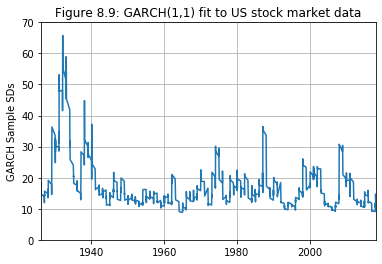

Stationary check (less than one):  0.9836839729663693
Long-term annualized standard deviation:  21.97413987975298


In [10]:
#fit GARCH(1,1) model
initparams=[.12,.85,.6]
a,b,c=qf.Garch11Fit(initparams,ActualReality)

#Display results
print("a=%.3f" % a)
print("b=%.3f" % b)
print("c=%.3f" % c)

#Draw graph
t=len(ActualReality)
minimal=10**(-20)
stdgarch=np.zeros(t)
stdgarch[0]=np.std(ActualReality)
overallmean=np.mean(ActualReality)
degarched=np.zeros(t)   #series to hold de-garched series y[t]/sigma[t]
degarched[0]=(ActualReality[0]-overallmean)/stdgarch[0]
#Compute GARCH(1,1) stddev's from data given parameters
for i in range(1,t):
    #Note offset - i-1 observation of data
    #is used for i estimate of std deviation
    previous=stdgarch[i-1]**2
    var=c+b*previous+\
        a*(ActualReality[i-1]-overallmean)**2
    stdgarch[i]=np.sqrt(var)
    degarched[i]=(ActualReality[i]-overallmean)/stdgarch[i]

#Annualize
stdgarch*=np.sqrt(12)

#Just show years
Year=[d/100 for d in Date]
    
plt.plot(Year,stdgarch)
plt.grid()
plt.title('Figure 8.9: GARCH(1,1) fit to US stock market data')
plt.ylabel('GARCH Sample SDs')
plt.axis([min(Year),max(Year),0,70])
plt.show();

print("Stationary check (less than one): ",a+b)
print("Long-term annualized standard deviation: ", \
      np.sqrt(12*c/(1-a-b)))

The parameters show that the LML solution was stationary. The long-term annualized standard deviation projected at the end of last year was a little higher than the sample standard deviation over the entire period back to mid-1926, but is of the same order of magnitude.


In [11]:
#Compute before and after excess kurtosis
from scipy import stats
kurt_orig=stats.kurtosis(ActualReality,fisher=True)
kurt_degarch=stats.kurtosis(degarched,fisher=True)
print("Excess kurtois before and after deGarching:", \
      kurt_orig,kurt_degarch)

Excess kurtois before and after deGarching: 6.903227841255099 2.308075473853875


The original US stock market time series had an excess kurtosis of 6.9. The "de-GARCHed" series is $y_i/\sigma_i$. Its excess kurtosis drops to 2.3 &mdash; one third of the original. It's not quite zero which would make the distribution pretty close to normal. But it's much closer.

### 8.5.1 ARCH and GARCH variants ###

Over the years, an enormous set of variants on GARCH have been proposed and used. We will mention a few of them.

A recurring empirical regularity is an asymmetric response to returns: positive returns tend to be followed by less of an increase in volatility than do negative returns. But all the $y$ terms in \eqref{eq:garchpq_sigma} are squared, so the GARCH(p,q) model does not differentiate between volatility responses to positive and negative returns.

For theoretical background on why this asymmetry might exist, we turn to the **`Merton Model`**, named after Robert Merton. Merton won the [The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel](https://www.nobelprize.org/prizes/economic-sciences/1997/merton/biographical/) in 1997. 

At its simplest, the Merton Model assumes that companies have an enterprise value $E$ out of which they have to repay a certain amount of debt $D$. The stockholders get whatever is left over, $S$. So $E=D+S$. Debt holders have first claim on the assets of the enterprise, so if $E<D$, they get everything and the stockholders get nothing. On the other hand $D$ is fixed – the debt holders don't participate if the company grows.
![](merton_model.jpg)

In 1974, [Merton](https://doi.org/10.1111/j.1540-6261.1974.tb03058.x) noted that the payoff pattern to debtholders &mdash; linearly increasing in $E$ for $0<E<D$, and capped at $D$ when $E>D$ &mdash; is the same as the payoff pattern to someone who owns the corporation (i.e. owns $E$) but who has also sold a call option on the corporation struck at price $D$. The stockholders own the call option on the enterprise value, struck at $D$.

When the call option is far in the money &mdash; i.e. the value of the enterprise is much higher than $D$ &mdash; then changes in the value of the enterprise cause comparatively small percentage changes in the value of the stock (i.e. the option on the enterprise that the stockholders own).

However as the value of the enterprise gets smaller and closer to the value of the debt $D$, the percentage swings in the stock get larger and larger as the company approaches bankruptcy and the shareholders approach zero value.

This argues in favor of asymmetric impact of returns. If there is a downward shock, that gets the value of the enterprise closer to the debt barrier and should increase volatility. If there is an upward shock, that gets the value of the enterprise further away from the debt barrier and should decrease volatility.

One way of dealing with this is to have a threshold on the shocks $y_t$. This gives rise to a variety of models with names like TARCH, TGARCH, and QTARCH. The [GJR (Glosten, Jagannathan, Runkle) 1993 TARCH model](https://www.jstor.org/stable/2329067) added a term that gave an extra boost to variance when there were negative returns:
$$\sigma_t^2=a_1 y_{t-1}^2+\delta(y_{t-1}<0) a_1^{-} y_{t-1}^2\label{eq:tarch_model}\tag{8.50}$$
The $\delta$ function equals one when its Boolean argument is true, and equals zero otherwise. This is like \eqref{eq:arch_sigma} with $p=1$, but the extra term adds the desired asymmetry. An obvious extension can be made for $p>1$.

Another straightforward implementation is a TGARCH model, where we take the GARCH(1,1) model in \eqref{eq:garch11_sigma} and add another term for down-shocks:
$$\sigma_t^2=c+b_1 \sigma_{t-1}^2+a_1 y_{t-1}^2+\delta(y_{t-1}<0) a_1^{-} y_{t-1}^2\label{eq:tgarch_model}\tag{8.51}$$

The QTARCH model generalizes the delta function from positive/negative to pick out segments of the shock distribution – for example we could have different responses if the shock was between -1% and -5% than if it was between -5% and -12%. Of course the more parameters that are added to a model, the more chance there is of overfitting past data and degrading out-of-sample performance.

Another approach that may not suffer as much from overfitting is to change the abrupt transition caused by the delta functions in \eqref{eq:tarch_model} and \eqref{eq:tgarch_model} to a smoother transition. Let $s(x)=1/(1+\text{exp}(kx))$. Note that as $k\to\infty$, $s(x)$ becomes the delta function $\delta(x<0)$. As we lower $k$, $s(x)$ still looks like the delta function but transitions more smoothly. We can use $(x-m)$ instead of $x$ to shift the transition point. Figure 8.10 illustrates this pseudo-delta function for some different values of $k$:

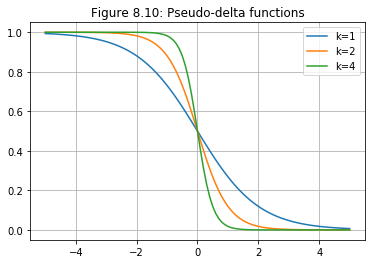

In [12]:
#Draw graph of pseudo-delta functions
xs=np.arange(-5,5.1,.1)
ks=[1,2,4]
for k in ks:
    ys=[1/(1+np.exp(k*x)) for x in xs]
    plt.plot(xs,ys,label='k='+str(k))

plt.legend()
plt.title('Figure 8.10: Pseudo-delta functions')
plt.grid()
plt.show()

Another GARCH variant is EGARCH, or Exponential GARCH. The idea is that there are various contortions we have to go through with the GARCH parameters to make sure that the variance comes out positive. We can avoid those contortions by taking the log of the variance, which can range over the positive and negative real numbers while still preserving positive variance.

The EGARCH model was specified in [Nelson 1991](www.jstor.org/stable/2938260). Nelson didn't mimic the original GARCH specification directly. He had a term that took into account asymmetric responses to positive and negative shocks. Translating into terms we have used, the EGARCH(1,1) model is:
$$ln(\sigma_t^2)=c+b_1 ln(\sigma_{t-1}^2)+a_1 y_{t-1}^2+\delta(y_{t-1}<0)a_1^{-}y_{t-1}^2\label{eq:egarch_model}\tag{8.52}$$
While this seems plausible, empirical tests done by [Engle and Ng 1993](https://doi.org/10.1111/j.1540-6261.1993.tb05127.x) show that EGARCH overweights the effects of big shocks and ends up fitting actual data more poorly than the GARCH model.

## Chapter 8 Footnotes
<a name="eight_footnotes"></a>
<br>
$^1$ Graham, Benjamin. Jason Zweig, ed., 2003 Edition. *The Intelligent Investor.* HarperCollins. ISBN 0-06-055566-1.
$^2$ https://www.gsarchive.net/mikado/webopera/mk208d.html
<br>
$^3$ “Greeks” are Greek letters that denote an instrument's sensitivity to various factors, such as interest Rates (rho), the passage of Time (theta), etc. Note in these examples that the Greek letter's name is the same as the associated variable - this is often but not always true. But there isn't a Greek letter starting with "v" for "volatility." "Vega" is actually the name of a star, but it sounds plausible. Purists who insist on using the real Greek alphabet, even if the initial letter of the name doesn't coincide with the associated variable, use "kappa" for volatility sensitivity.
<br>
$^4$ Ilya Glickman has a nice one-page proof of this here: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1756450
<br>
$^5$ Morini, Massimo. Understanding and Managing Model Risk. Wiley Finance, 2011.  ISBN-13: 978-0470977613. pp. 230-231.

In [13]:
#Extremely time-consuming processing of large options file downloaded from CBOE.
#File is UnderlyingOptionsEODCalcs_YYYY-12-31.xlsx
#and contains every option quote on the CBOE for that year-end date
import pandas as pd
import datetime
import time

#First subset out just the SPX options and output them to a smaller xlsx file.

yearend_string=str(datetime.datetime.now().year-1)+"-12-31"

#VERY LARGE dataset, takes a long time to read
start_time=time.perf_counter()
df_opts=pd.read_excel(r"UnderlyingOptionsEODCalcs_"+yearend_string+".xlsx")
end_time = time.perf_counter()
print("Reading done, %7.3f seconds" % (end_time-start_time))

#Subset the S&P 500 options with underlying SPX (eliminate SPXW, weekly expirations)
df_spx = df_opts[(df_opts.underlying_symbol == "^SPX") & (df_opts.root == "SPX")]
end_time, start_time = time.perf_counter(), end_time
print("SPX options subsetted, %7.3f seconds" % (end_time-start_time))
df_spx.to_excel(r"SPX_UnderlyingOptionsEODCalcs_"+yearend_string+".xlsx")
end_time, start_time = time.perf_counter(), end_time
print("SPX options written out, %7.3f seconds" % (end_time-start_time))

Reading done, 336.609 seconds
SPX options subsetted,   0.264 seconds
SPX options written out,   3.377 seconds


In [15]:
#df_opt contains very large dataset of all options at yearend
#Now find the tickers that are in SPY (the S&P 500 ETF)
#and subset those.

start_time = time.perf_counter()
df_spy=pd.read_excel("https://us.spdrs.com/site-content/xls/SPY_All_Holdings.xls", \
                    skiprows=3)
df_spy.dropna(axis=0, how='any', inplace=True)   #Clean up junk at the end
#Extract tickers and weights
orig_spy_tickers=[]
weights=[]
for i in range(len(df_spy)):
    orig_spy_tickers.append(df_spy["Ticker"].iloc(0)[i].upper())
    weights.append(df_spy["Weight"].iloc(0)[i])
        
#force weights to add to 1
weights/=sum(weights)
end_time = time.perf_counter()
print("%d SPY tickers input, %7.3f seconds" % (len(weights),end_time-start_time))

#Find 30-60 day expiration options for each SPY ticker.
#If those don't exist, try expirations outside that range.
#Put the found options in df_spy_options

for i in range(len(orig_spy_tickers)):
    df_this_tick=df_opts[df_opts.underlying_symbol == orig_spy_tickers[i]]
    if len(df_this_tick)>0:    #Did we find anything for this ticker?
        df_target = df_this_tick[ \
             (df_this_tick.expiration>quote_date+np.timedelta64(60,'D')) & \
             (df_this_tick.expiration<quote_date+np.timedelta64(90,'D'))]
        if len(df_target)==0:   #See if there are expirations before and after 3 months
            df_target = df_this_tick[ \
             (df_this_tick.expiration>quote_date+np.timedelta64(30,'D')) & \
             (df_this_tick.expiration<quote_date+np.timedelta64(120,'D'))]
        if len(df_target)>0:   #Did we find any expirations?
            if i == 0:
                df_spy_options = df_target   #First SPY ticker found
            else:
                df_spy_options=df_spy_options.append(df_target)


end_time, start_time = time.perf_counter(), end_time
print(len(df_spy_options),"SPY options found, %7.3f seconds" % (end_time-start_time))
               
#Output to xlsx file
df_spy_options.to_excel(r"SPY_UnderlyingOptionsEODCalcs_"+yearend_string+".xlsx")
end_time, start_time = time.perf_counter(), end_time
print("SPY options output, %7.3f seconds" % (end_time-start_time))

506 SPY tickers input,   1.106 seconds
45142 SPY options found,  36.329 seconds
SPY options output,  26.731 seconds
